In [1]:
import os.path as osp
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
import utils.hops_sampler as hops_sampler
import utils.cancer_data as pathway
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Load both data and operate by class pathway
pathwayPATH = './Gene_DATA/sourcePathway.txt'
cancerPATH = './BreastCancer/Data_RNASeq2.mat'

# load the overall pathway and cancer data in object
data = pathway.cancer_data(pthwayPATH=pathwayPATH, cancerPATH=cancerPATH)

# sample the protein for the regression problem 
hops_samples_obj = hops_sampler.hops_sampler(pathway = data, 
                                batch_size = 2, # must>1 
                                num_hops = 3,
                                label_all=True)

hops_sample_loader = hops_samples_obj.hops_samples

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_nodes = hops_samples_obj.data.pthway_NameList.shape[0]
model = Node2Vec(num_nodes, embedding_dim=16, walk_length=20,
                 context_size=10, walks_per_node=10)
model= model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [4]:
hops_sample_loader[0].edge_index_oriIndexxed

array([[  124,   124,   124, ..., 15679, 15785, 15785],
       [  124,  1973,  7467, ..., 15679, 11759, 15785]])

In [5]:
def train():
    model.train()
    total_loss = 0
    for subset in hops_sample_loader:
        optimizer.zero_grad()
        batch = torch.from_numpy(subset.batch).long().to(device)
        edge_index = torch.from_numpy(subset.edge_index_oriIndexxed).long().to(device)
        loss = model.loss(edge_index, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(hops_sample_loader)

In [6]:

for epoch in range(1, 500):
    loss = train()
    print('Epoch: {:02d}, Loss: {:.4f}'.format(epoch, loss))

Epoch: 01, Loss: 2.2978
Epoch: 02, Loss: 1.1874
Epoch: 03, Loss: 0.7379
Epoch: 04, Loss: 0.5916
Epoch: 05, Loss: 0.5209
Epoch: 06, Loss: 0.4801
Epoch: 07, Loss: 0.4547
Epoch: 08, Loss: 0.4370
Epoch: 09, Loss: 0.4227
Epoch: 10, Loss: 0.4098
Epoch: 11, Loss: 0.3981
Epoch: 12, Loss: 0.3864
Epoch: 13, Loss: 0.3761
Epoch: 14, Loss: 0.3674
Epoch: 15, Loss: 0.3595
Epoch: 16, Loss: 0.3528
Epoch: 17, Loss: 0.3469
Epoch: 18, Loss: 0.3417
Epoch: 19, Loss: 0.3378
Epoch: 20, Loss: 0.3337
Epoch: 21, Loss: 0.3301
Epoch: 22, Loss: 0.3272
Epoch: 23, Loss: 0.3245
Epoch: 24, Loss: 0.3216
Epoch: 25, Loss: 0.3199
Epoch: 26, Loss: 0.3173
Epoch: 27, Loss: 0.3156
Epoch: 28, Loss: 0.3139
Epoch: 29, Loss: 0.3122
Epoch: 30, Loss: 0.3109
Epoch: 31, Loss: 0.3095
Epoch: 32, Loss: 0.3080
Epoch: 33, Loss: 0.3071
Epoch: 34, Loss: 0.3056
Epoch: 35, Loss: 0.3049
Epoch: 36, Loss: 0.3038
Epoch: 37, Loss: 0.3032
Epoch: 38, Loss: 0.3024
Epoch: 39, Loss: 0.3015
Epoch: 40, Loss: 0.3012
Epoch: 41, Loss: 0.3004
Epoch: 42, Loss:

In [7]:
model.eval()
with torch.no_grad():
    z = model(torch.arange(num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.node_class

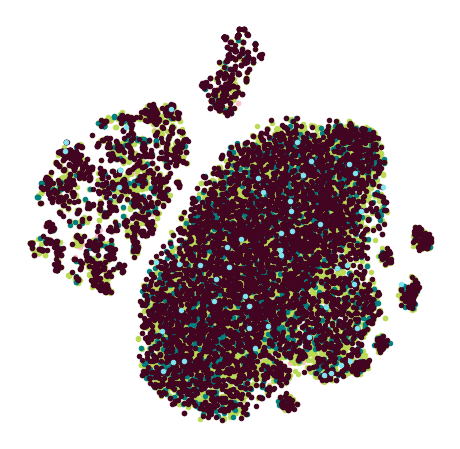

In [8]:
#def plot_points(colors):
#     model.eval()
#     with torch.no_grad():
#         z = model(torch.arange(num_nodes, device=device))
#         z = TSNE(n_components=3).fit_transform(z.cpu().numpy())
#         y = data.node_class
 
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
#ax = Axes3D(plt.figure())
plt.figure(figsize=(8, 8))
for i in range(7):
    plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
plt.axis('off')
plt.savefig('./results/node2vec-embedding/March-25th/node2vec_embed.pdf')
plt.show()

#plot_points(colors)

In [9]:
torch.save(model.state_dict(), './model-dict/node2vec-predembedding/node2vec_16dim.pth')